# Peak calling DL model

## Setup

### Create an environment

#### Paste this in your terminal while in this directory and select the 'DL_peak_calling' kernel

```
conda create -n DL_peak_calling -c conda-forge mamba python=3.9 -y && \
conda activate DL_peak_calling && \
mamba env update --file environment.yml
```

### Import and configure libraries

In [1]:
import os
import pickle
from time import time, gmtime, strftime
from collections import Counter
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import f1_score
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.image import imread
# Uncomment to use dark plots
# plt.style.use('dark_background')
import seaborn as sns

from IPython.display import clear_output
import nbformat
# Automatically choose import based on the file type
if 'get_ipython' in globals():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

SKYBLUE = '#B3E6FF'
INDIGO = '#4B0082'
LAVENDER = '#F0CCFF'
MAGENTA = '#D166FF'

### Set a number of workers

In [2]:
# Specify instead of 'None' if necessary
num_workers = None

if not num_workers:
    num_workers = cpu_count()

num_workers

96

### Set a device

In [3]:
# To manually set a device specify it instead of 'None' (if necessary)
device = torch.device('cuda:1')

# Automatically set a better device
if not device:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up a hyperparameter for distributed training
if device.type == 'cuda':
    world_size = torch.cuda.device_count()

## Retrieve the data

#### Retrieve dyad positions

In [4]:
%%bash


for i in 1 2 3
do
    mkdir dataset_${i} -p

    wget \
        https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM256105$((i+6))/suppl/GSM256105$((i+6))%5FDyads%5FH3%5FCC%5Frep%5F${i}%2Ebw \
        -O dataset_${i}/dyads.bw \
        --no-verbose
done

2024-07-25 16:07:30 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561057/suppl/GSM2561057%5FDyads%5FH3%5FCC%5Frep%5F1%2Ebw [10064746/10064746] -> "dataset_1/dyads.bw" [1]
2024-07-25 16:07:32 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561058/suppl/GSM2561058%5FDyads%5FH3%5FCC%5Frep%5F2%2Ebw [8556133/8556133] -> "dataset_2/dyads.bw" [1]
2024-07-25 16:07:34 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561059/suppl/GSM2561059%5FDyads%5FH3%5FCC%5Frep%5F3%2Ebw [7220516/7220516] -> "dataset_3/dyads.bw" [1]


#### Retrieve the [S. cerevisiae (sacCer3) reference genome](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000146045.2/)

In [55]:
! wget \
    https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz \
    -O reference_genome.fasta.gz

! gunzip reference_genome.fasta.gz

--2024-07-26 16:14:44--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.12, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3843460 (3.7M) [application/x-gzip]
Saving to: ‘reference_genome.fasta.gz’

reference_genome.fa 100%[===================>]   3.67M  2.64MB/s    in 1.4s    

2024-07-26 16:14:46 (2.64 MB/s) - ‘reference_genome.fasta.gz’ saved [3843460/3843460]



#### Retrieve MNase-Exo-Seq sequence alignment map

In [6]:
%%bash


gdown \
    'https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1' \
    -O exoiii_dataset/exo.bam

samtools \
    view \
    exoiii_dataset/exo.bam > exoiii_dataset/exo.sam

Downloading...
From (original): https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1
From (redirected): https://drive.google.com/uc?id=1WUPP3z_KrBmIrCyF-ogpQX8qNs5v3ez1&confirm=t&uuid=c4bff46d-d814-4461-a9be-a623b5b6bb1c
To: /home/v_sidorov/DL_peak_calling/exoiii_dataset/exo.bam
100%|██████████| 245M/245M [00:23<00:00, 10.5MB/s] 


## Analyse the data

### Load the data

#### Load the SAM file

In [33]:
exo_tlens = pd.read_csv(
    'exoiii_dataset/exo.sam',
    sep='\t',
    names=['tlen'],
    usecols=[8],
)

exo_tlens

,tlen
0,117
1,57
2,54
3,-54
4,-57
...,...
8920963,-143
8920964,-85
8920965,-141
8920966,-145


#### Load the dyad probability distributions dictionary

In [34]:
with open('exoiii_dataset/exo_dyad_dists.pickle', 'rb') as file:
    exo_dyad_dists = pickle.load(file)

### Analyse the data

#### Get an MNase-Exo-seq template length distribution

In [35]:
exo_tlen_dist = exo_tlens.tlen
exo_tlen_dist = exo_tlens[exo_tlen_dist.between(0, 200)] \
                                                .groupby(exo_tlen_dist) \
                                                .count()
exo_tlen_dist = exo_tlen_dist.loc[78:]
exo_tlen_dist = exo_tlen_dist / exo_tlen_dist.sum()

exo_tlen_dist

,tlen
tlen,
78,0.000264
79,0.000276
80,0.000303
81,0.000352
82,0.000381
...,...
196,0.000019
197,0.000011
198,0.000015


#### Look at the MNase-Exo-seq template length distribution

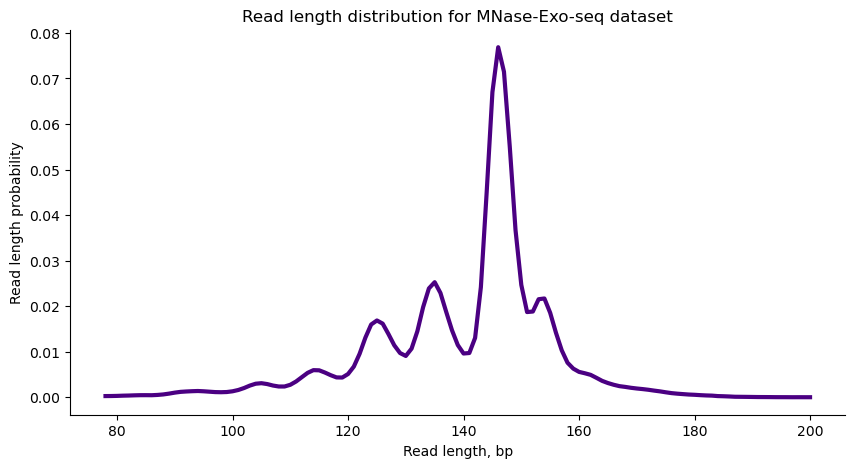

In [36]:
plt.figure(figsize=(10, 5))

ax = sns.lineplot(
    exo_tlen_dist.tlen,
    color=INDIGO,
    linewidth=3
)

plt.title('Read length distribution for MNase-Exo-seq dataset')
plt.xlabel('Read length, bp')
plt.ylabel('Read length probability')
plt.legend([], [], frameon=False)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

#### Define a function to sample a random template length from the MNase-Exo-seq template length distribution

In [37]:
def get_random_tlen():
    '''
    Samples a random template length (78–200 inclusively) from the MNase-Exo-seq template length distribution.
    
    Returns
    -------
    tlen : int
        Template length.
    '''
    tlen =  np.random.choice(
        np.arange(78, 201),
        p=exo_tlen_dist.tlen
    )
    
    return tlen

#### Look at a dyad probability distribution at an arbitrary read length

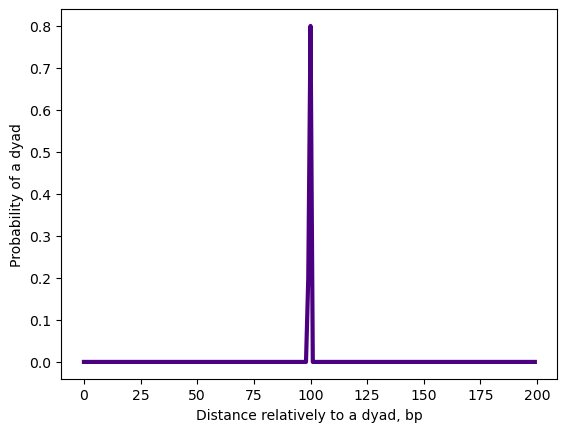

In [563]:
ax = sns.lineplot(
    exo_dyad_dists[200],
    linewidth=3,
    color=INDIGO
)

plt.xlabel('Distance relatively to a dyad, bp')
plt.ylabel('Probability of a dyad')

plt.show()

#### Define a function to sample a random dyad position from the MNase-Exo-seq dyad distribution

In [39]:
def get_random_exo_dyad_pos(length):
    '''
    Samples a random dyad position from an MNase-Exo-seq dyad distribution for a given length.
    
    Parameters
    ----------
    length : int
        Length of the template to sample from.
    
    Returns
    -------
    dyad_pos : int
        Random 1-based position of a dyad on the template of the given length.
    '''
    dyad_pos = np.random.choice(
        np.arange(1, 201),
        p=list(exo_dyad_dists[length])
    )
    
    return dyad_pos

## Prepare a dataset

### Extract dyad positions

#### Convert .bw dyad positions to .bed, removing the first non-informative line

In [40]:
%%bash

for i in 1 2 3
do
    bigWigToBedGraph dataset_${i}/dyads.bw dataset_${i}/dyads.bed

    sed 1d dataset_${i}/dyads.bed > dataset_${i}/dyads_tmp.bed

    mv dataset_${i}/dyads_tmp.bed dataset_${i}/dyads.bed
done

head -n 5 dataset_1/dyads.bed

chrI	32	33	2.572
chrI	33	38	0
chrI	38	39	7.715
chrI	39	66	0
chrI	66	67	12.859


#### Load the dyad positions

In [41]:
def load_dyad_positions(dataset_number):
    raw_dyad_positions = pd.read_csv(
        f'dataset_{dataset_number}/dyads.bed',
        sep='\t',
        usecols=[0, 2, 3],
        names=['chr', 'dyad_pos', 'signal']
    )
    return raw_dyad_positions


raw_dyad_positions_1 = load_dyad_positions(1)
raw_dyad_positions_2 = load_dyad_positions(2)
raw_dyad_positions_3 = load_dyad_positions(3)

raw_dyad_positions_1

,chr,dyad_pos,signal
0,chrI,33,2.572
1,chrI,38,0.000
2,chrI,39,7.715
3,chrI,66,0.000
4,chrI,67,12.859
...,...,...,...
3383780,chrXVI,948031,0.000
3383781,chrXVI,948032,7.568
3383782,chrXVI,948034,0.000
3383783,chrXVI,948035,5.046


#### Look at signal probability distributions

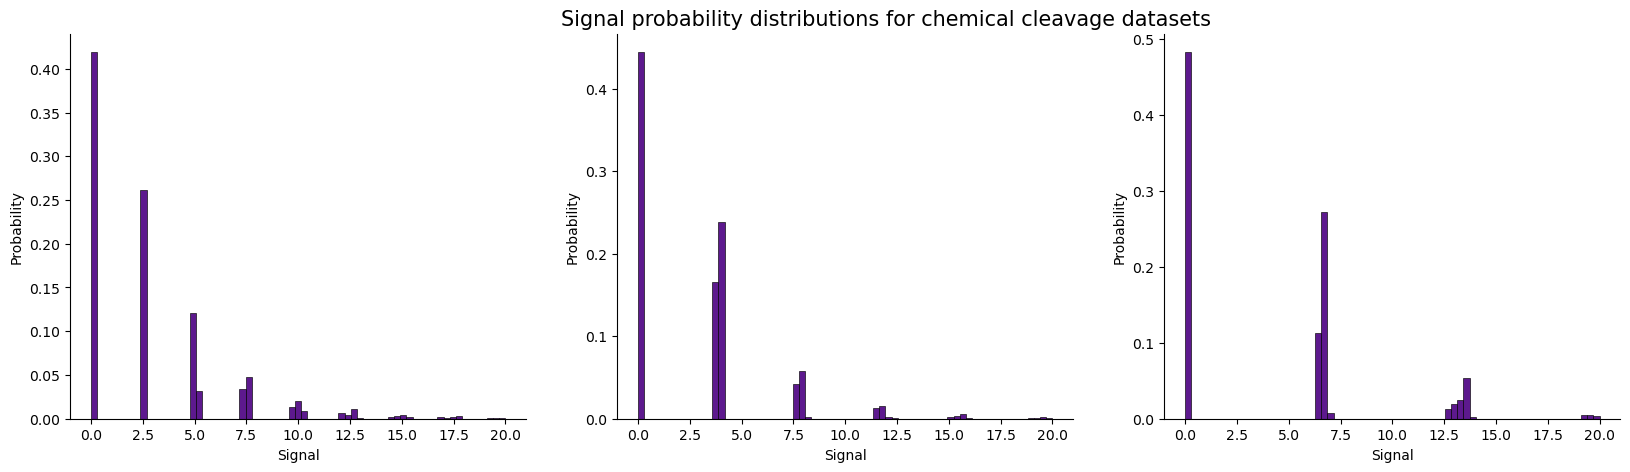

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    sns.histplot(
        eval(f'raw_dyad_positions_{i+1}.signal'),
        binwidth=0.3,
        binrange=(0, 20),
        color=INDIGO,
        alpha=0.9,
        stat='probability',
        ax=ax[i]
    )
    ax[i].set_xlabel('Signal')
    ax[i].set_ylabel('Probability')
    ax[i].spines[['right', 'top']].set_visible(False)

plt.title(
    'Signal probability distributions for chemical cleavage datasets',
    fontsize=15,
    x=-0.61
)

plt.show()

#### Filter rows with low signal

In [43]:
def filter_rows_wo_signal(raw_dyad_positions):
    dyad_positions = raw_dyad_positions \
        .query('signal > 7') \
        .drop('signal', axis=1) \
        .reset_index(drop=True)
    return dyad_positions


dyad_positions_1 = filter_rows_wo_signal(raw_dyad_positions_1)
dyad_positions_2 = filter_rows_wo_signal(raw_dyad_positions_2)
dyad_positions_3 = filter_rows_wo_signal(raw_dyad_positions_3)

dyad_positions_1

,chr,dyad_pos
0,chrI,39
1,chrI,67
2,chrI,94
3,chrI,100
4,chrI,129
...,...,...
594211,chrXVI,947724
594212,chrXVI,947817
594213,chrXVI,947840
594214,chrXVI,948030


### Calculate template positions

#### Calculate template positions

In [565]:
def get_template_position(dyad_pos):
    # Get random dyad position in the internal tempalte's reference frame
    # tlen = get_random_tlen()
    tlen = 200
    internal_dyad_pos = get_random_exo_dyad_pos(tlen)
    
    # Calculate template's boundaries
    start_pos = dyad_pos - internal_dyad_pos - 1
    stop_pos = start_pos + tlen
    
    return start_pos, internal_dyad_pos, stop_pos


def calc_template_positions(dyad_positions):
    with Pool(num_workers) as pool:
        iterator = pool.imap(get_template_position, dyad_positions['dyad_pos'])
        result = np.array(list(tqdm(
            iterator,
            total=len(dyad_positions),
            colour=INDIGO
        )))
    
    template_positions = dyad_positions.assign(
        start_pos=result[:, 0],
        internal_dyad_pos=result[:, 1],
        stop_pos=result[:, 2]
    )

    return template_positions


template_positions_1 = calc_template_positions(dyad_positions_1)
template_positions_2 = calc_template_positions(dyad_positions_2)
template_positions_3 = calc_template_positions(dyad_positions_3)

template_positions_1

  0%|          | 0/594216 [00:00<?, ?it/s]

  0%|          | 0/506830 [00:00<?, ?it/s]

  0%|          | 0/323248 [00:00<?, ?it/s]

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,chrI,39,-62,100,138
1,chrI,67,-34,100,166
2,chrI,94,-7,100,193
3,chrI,100,-1,100,199
4,chrI,129,28,100,228
...,...,...,...,...,...
594211,chrXVI,947724,947622,101,947822
594212,chrXVI,947817,947716,100,947916
594213,chrXVI,947840,947738,101,947938
594214,chrXVI,948030,947928,101,948128


#### Filter template positions to be inside the reference genome

In [566]:
def filter_max_stop_positions(template_positions):
    max_positions = template_positions.groupby('chr')['stop_pos'].max() - 200
    
    filtered_template_positions = pd.merge(
        template_positions,
        max_positions,
        on='chr',
        suffixes=('', '_max')
    )
    filtered_template_positions = filtered_template_positions \
        .query('(start_pos > 0) & (stop_pos< stop_pos_max)') \
        .drop('stop_pos_max', axis=1) \
        .reset_index(drop=True)
    
    return filtered_template_positions

filtered_template_positions_1 = filter_max_stop_positions(template_positions_1)
filtered_template_positions_2 = filter_max_stop_positions(template_positions_2)
filtered_template_positions_3 = filter_max_stop_positions(template_positions_3)

filtered_template_positions_1

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,chrI,129,28,100,228
1,chrI,133,32,100,232
2,chrI,135,34,100,234
3,chrI,139,38,100,238
4,chrI,146,45,100,245
...,...,...,...,...,...
593999,chrXVI,947720,947619,100,947819
594000,chrXVI,947721,947620,100,947820
594001,chrXVI,947722,947620,101,947820
594002,chrXVI,947724,947622,101,947822


#### Calculate collateral dyad positions

In [567]:
def calc_collateral_dyad_positions(template_positions):
    template_positions['dyad_pos'] = template_positions['dyad_pos'].astype('int32')
    template_positions['chr'] = template_positions['chr'].astype('category')

    def get_internal_positions(row):
        query = f'dyad_pos >= {row.start_pos} and dyad_pos <= {row.stop_pos} and chr == "{row.chr}"'
        internal_dyad_positions = template_positions.query(query)['dyad_pos'] - row.start_pos - 1
        internal_dyad_positions = internal_dyad_positions.tolist()
        
        return internal_dyad_positions
    
    tqdm.pandas(colour=INDIGO)
    internal_dyad_positions = template_positions.progress_apply(get_internal_positions, axis=1)
    
    multilabel_template_positions = template_positions \
        .copy() \
        .rename(columns={'internal_dyad_pos': 'internal_dyad_positions'})
    multilabel_template_positions['internal_dyad_positions'] = internal_dyad_positions

    return multilabel_template_positions


multilabel_template_positions_1 = calc_collateral_dyad_positions(filtered_template_positions_1)
multilabel_template_positions_2 = calc_collateral_dyad_positions(filtered_template_positions_2)
multilabel_template_positions_3 = calc_collateral_dyad_positions(filtered_template_positions_3)

multilabel_template_positions_1

  0%|          | 0/594004 [00:00<?, ?it/s]

  0%|          | 0/506700 [00:00<?, ?it/s]

  0%|          | 0/322808 [00:00<?, ?it/s]

,chr,dyad_pos,start_pos,internal_dyad_positions,stop_pos
0,chrI,129,28,"[100, 104, 106, 110, 117, 123, 136, 175, 185, ...",228
1,chrI,133,32,"[96, 100, 102, 106, 113, 119, 132, 171, 181, 1...",232
2,chrI,135,34,"[94, 98, 100, 104, 111, 117, 130, 169, 179, 18...",234
3,chrI,139,38,"[90, 94, 96, 100, 107, 113, 126, 165, 175, 181...",238
4,chrI,146,45,"[83, 87, 89, 93, 100, 106, 119, 158, 168, 174,...",245
...,...,...,...,...,...
593999,chrXVI,947720,947619,"[19, 76, 79, 84, 91, 92, 98, 99, 100, 101, 102...",947819
594000,chrXVI,947721,947620,"[18, 75, 78, 83, 90, 91, 97, 98, 99, 100, 101,...",947820
594001,chrXVI,947722,947620,"[18, 75, 78, 83, 90, 91, 97, 98, 99, 100, 101,...",947820
594002,chrXVI,947724,947622,"[16, 73, 76, 81, 88, 89, 95, 96, 97, 98, 99, 1...",947822


#### Cache the dyad positions

In [568]:
def cache_dyad_positions(dataset_number):
    if not os.path.exists(f'dataset_{dataset_number}/cache'):
        os.makedirs(f'dataset_{dataset_number}/cache')
        
    with open(f'dataset_{dataset_number}/cache/internal_dyad_positions.pickle', 'wb') as file:
        pickle.dump(eval(f'multilabel_template_positions_{dataset_number}.internal_dyad_positions'), file)


cache_dyad_positions(1)
cache_dyad_positions(2)
cache_dyad_positions(3)

### Get template sequences based on the template positions

#### Substitute 'chr' column values with NCBI identifiers

In [582]:
# Make a dictionary manually using NCBI data
chr_to_id = {
    'chrI': 'NC_001133.9',
    'chrII': 'NC_001134.8',
    'chrIII': 'NC_001135.5',
    'chrIV': 'NC_001136.10',
    'chrV': 'NC_001137.3',
    'chrVI': 'NC_001138.5',
    'chrVII': 'NC_001139.9',
    'chrVIII': 'NC_001140.6',
    'chrIX': 'NC_001141.2',
    'chrX': 'NC_001142.9',
    'chrXI': 'NC_001143.9',
    'chrXII': 'NC_001144.5',
    'chrXIII': 'NC_001145.3',
    'chrXIV': 'NC_001146.8',
    'chrXV': 'NC_001147.6',
    'chrXVI': 'NC_001148.4'
}


def convert_chr_to_id(template_positions):
    template_positions['chr'] = template_positions['chr'].cat.rename_categories(chr_to_id)
    
    return template_positions


renamed_template_positions_1 = convert_chr_to_id(filtered_template_positions_1)
renamed_template_positions_2 = convert_chr_to_id(filtered_template_positions_2)
renamed_template_positions_3 = convert_chr_to_id(filtered_template_positions_3)

renamed_template_positions_1

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,NC_001133.9,129,28,100,228
1,NC_001133.9,133,32,100,232
2,NC_001133.9,135,34,100,234
3,NC_001133.9,139,38,100,238
4,NC_001133.9,146,45,100,245
...,...,...,...,...,...
593999,NC_001148.4,947720,947619,100,947819
594000,NC_001148.4,947721,947620,100,947820
594001,NC_001148.4,947722,947620,101,947820
594002,NC_001148.4,947724,947622,101,947822


#### Load template positions into a bedGraph file

In [570]:
def templates_to_bedgraph(renamed_template_positions, dataset_number):
    renamed_template_positions[['chr', 'start_pos', 'stop_pos']].to_csv(
        f'dataset_{dataset_number}/templates.bed',
        sep='\t',
        index=False,
        header=False
    )


templates_to_bedgraph(renamed_template_positions_1, 1)
templates_to_bedgraph(renamed_template_positions_2, 2)
templates_to_bedgraph(renamed_template_positions_3, 3)

! head -n 5 dataset_1/templates.bed

NC_001133.9	28	228
NC_001133.9	32	232
NC_001133.9	34	234
NC_001133.9	38	238
NC_001133.9	45	245


#### Extract sequences from a FASTA file based on positions in bedGraph file

In [571]:
%%bash

for i in 1 2 3
do
    bedtools getfasta \
        -fi reference_genome.fasta \
        -bed dataset_${i}/templates.bed \
        -fo dataset_${i}/templates.fasta
done

rm reference_genome.fasta.fai

head -n 5 dataset_1/templates.fasta

>NC_001133.9:28-228
acaccacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTTACTACCACTCACCCACCGTTACCCTCCA
>NC_001133.9:32-232
cacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTTACTACCACTCACCCACCGTTACCCTCCAATTA
>NC_001133.9:34-234


#### Parse the FASTA file

In [572]:
def parse_fasta_templates(dataset_number):
    fasta_templates = SeqIO.parse(f'dataset_{dataset_number}/templates.fasta', 'fasta')

    templates = list(
        map(
            lambda record: list(str(record.seq).upper()),
            fasta_templates
        )
    )
    
    return templates


templates_1 = parse_fasta_templates(1)
templates_2 = parse_fasta_templates(2)
templates_3 = parse_fasta_templates(3)

print(templates_1[0])

['A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'T', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'T', 'A', 'C', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'A', 'G', 'C', 'C', 'C', 'T', 'A', 'A', 'T', 'C', 'T', 'A', 'A', 'C', 'C', 'C', 'T', 'G', 'G', 'C', 'C', 'A', 'A', 'C', 'C', 'T', 'G', 'T', 'C', 'T', 'C', 'T', 'C', 'A', 'A', 'C', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'C', 'C', 'A', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'C', 'C', 'T', 'C', 'C', 'A', 'C', 'T', 'C', 'G', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'T', 'C', 'C', 'C', 'A', 'T', 'T', 'C', 'A', 'A', 'C', 'C', 'A', 'T', 'A', 'C', 'C', 'A', 'C', 'T', 'C', 'C', 'G', 'A', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'T', 'C', 'C', 'A', 'T', 'C', 'C', 'C', 'T', 'C', 'T', 'A', 'C', 'T', 'T', 'A', 'C', 'T', 'A', 'C', 'C', 'A', 'C', 'T', 'C', 'A', 'C', 'C', 'C', 'A', 'C', 'C', 'G', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'C', 'C', 'A']

#### Cache the templates

In [573]:
def cache_templates(dataset_number):
    if not os.path.exists(f'dataset_{dataset_number}/cache'):
        os.makedirs(f'dataset_{dataset_number}/cache')
        
    with open(f'dataset_{dataset_number}/cache/templates.pickle', 'wb') as file:
        pickle.dump(eval(f'templates_{dataset_number}'), file)


cache_templates(1)
cache_templates(2)
cache_templates(3)

### Create a dataset and a dataloader

#### Create a one-hot encoded dataset

##### Define the Dataset class

In [4]:
class DefaultDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

        self.ohe = {
            'A': torch.tensor([1, 0, 0, 0], dtype=torch.float32),
            'C': torch.tensor([0, 1, 0, 0], dtype=torch.float32),
            'G': torch.tensor([0, 0, 1, 0], dtype=torch.float32),
            'T': torch.tensor([0, 0, 0, 1], dtype=torch.float32)
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        dyad_positions = self.targets[idx]

        # Encode sequence
        encoded_seq = torch.stack([self.ohe[nuc] for nuc in seq])

        # Encode dyad position
        encoded_dyad_positions = torch.zeros(200)
        encoded_dyad_positions[dyad_positions] = 1

        return encoded_seq, encoded_dyad_positions


class BigramDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

        self.nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        dyad_positions = self.targets[idx] - 1

        label_encoded_seq = [self.nuc_to_idx[nuc] for nuc in seq]

        # Create bi-grams
        bigrams = []
        for i in range(len(label_encoded_seq) - 1):
            bigrams.append((label_encoded_seq[i], label_encoded_seq[i+1]))

        # One-hot encode sequence
        one_hot_encoded_seq = []
        for bigram in bigrams:
            bigram_idx = bigram[0] * 16 + bigram[1] * 4 + bigram[2]
            one_hot_encoded_seq.append(np.eye(16)[bigram_idx])
        one_hot_encoded_seq = torch.tensor(np.array(one_hot_encoded_seq), dtype=torch.float32)

        # Encode dyad position
        encoded_dyad_positions = torch.zeros(200)
        encoded_dyad_positions[dyad_positions] = 1

        return one_hot_encoded_seq, encoded_dyad_positions


class TrigramDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

        self.nuc_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        dyad_positions = self.targets[idx] - 2

        label_encoded_seq = [self.nuc_to_idx[nuc] for nuc in seq]

        # Create 3-grams
        trigrams = []
        for i in range(len(label_encoded_seq) - 2):
            trigrams.append((label_encoded_seq[i:i+3]))

        # One-hot encode sequence
        one_hot_encoded_seq = []
        for trigram in trigrams:
            c
            one_hot_encoded_seq.append(np.eye(64)[trigram_idx])
        one_hot_encoded_seq = torch.tensor(np.array(one_hot_encoded_seq), dtype=torch.float32)
        
        # Encode dyad position
        encoded_dyad_positions = torch.zeros(200)
        encoded_dyad_positions[dyad_positions] = 1

        return one_hot_encoded_seq, encoded_dyad_positions

##### Load the templates

In [5]:
def load_templates(dataset_number):
    with open(f'dataset_{dataset_number}/cache/templates.pickle', 'rb') as file:
        templates = pickle.load(file)
    
    return templates

##### Load the dyad positions

In [6]:
def load_internal_dyad_positions(dataset_number):
    with open(f'dataset_{dataset_number}/cache/internal_dyad_positions.pickle', 'rb') as file:
        internal_dyad_positions = pickle.load(file)
    
    return internal_dyad_positions

##### Create the dataset

In [7]:
def create_dataset(
    templates,
    internal_dyad_positions,
    dataset_prefix,
    dataset_number
    ):
    if dataset_prefix == 'default':
        return DefaultDataset(templates, internal_dyad_positions)
    
    elif dataset_prefix == 'bigram':
        return BigramDataset(templates, internal_dyad_positions)
    
    elif dataset_prefix == 'trigram':
        return TrigramDataset(templates, internal_dyad_positions)

#### Split the dataset into training validation and testing sets

In [17]:
def split_dataset(dataset):
    # indices = np.random.choice(range(len(dataset)), 100000)
    # dataset = torch.utils.data.Subset(dataset, indices)
    
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    datasets = {}
    datasets['train'], datasets['val'], datasets['test'] = random_split(dataset, [train_size, val_size, test_size])
    
    return datasets

#### Define distributed samplers for multiple GPU usage

In [9]:
def create_dist_samplers(dataset, world_size, rank):
    samplers = {}
    
    samplers['train'] = DistributedSampler(dataset['train'], num_replicas=world_size, rank=rank)
    samplers['val'] = DistributedSampler(dataset['val'], num_replicas=world_size, rank=rank)
    samplers['test'] = DistributedSampler(dataset['test'], num_replicas=world_size, rank=rank)
    
    return samplers

#### Create dataloaders

In [10]:
def create_dataloaders(split_dataset, batch_size, samplers):
    dataloader = {}
    if samplers == None:
        dataloader['train'] = DataLoader(
            split_dataset['train'],
            batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True
        )
        dataloader['val'] = DataLoader(
            split_dataset['val'],
            batch_size,
            drop_last=True,
            pin_memory=True
        )
        dataloader['test'] = DataLoader(
            split_dataset['test'],
            batch_size,
            drop_last=True,
            pin_memory=True
        )
        
    else:
        dataloader['train'] = DataLoader(
            split_dataset['train'],
            batch_size,
            drop_last=True,
            pin_memory=True,
            sampler=samplers['train']
        )
        dataloader['val'] = DataLoader(
            split_dataset['val'],
            batch_size,
            drop_last=True,
            pin_memory=True,
            sampler=samplers['val']
        )
        dataloader['test'] = DataLoader(
            split_dataset['test'],
            batch_size,
            drop_last=True,
            pin_memory=True,
            sampler=samplers['test']
        )
    
    return dataloader

#### Define a function to prepare dataloaders from the raw data

In [11]:
def prepare_dataloaders(
    dataset_prefix,
    dataset_number,
    batch_size,
    world_size,
    rank,
    distributed
    ):
    templates = load_templates(dataset_number)
    internal_dyad_positions = load_internal_dyad_positions(dataset_number)
    dataset = create_dataset(templates, internal_dyad_positions, dataset_prefix, dataset_number)
    datasets = split_dataset(dataset)
    samplers = None
    if distributed:
        samplers = create_dist_samplers(datasets, world_size, rank)
    dataloaders = create_dataloaders(datasets, batch_size, samplers)
    
    return dataloaders

## Create the model

### Define a model

In [12]:
class MulticlassBiGRU(nn.Module):
    def __init__(self, dataset_prefix, hidden_size, num_layers):
        super().__init__()
        
        ngram_symbol_num = {
            'default': 1,
            'bigram': 2,
            'trigram': 3
            
        }
        
        self.bigru = nn.GRU(
            input_size=4**ngram_symbol_num[dataset_prefix],
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.softmax = nn.Softmax(dim=1)
    
    def __repr__(self):
        return 'MulticlassBiGRU'

    def forward(self, x):
        bigru_output, _ = self.bigru(x) # (batch_size, length, hidden_size * 2)
        fc_output = self.fc(bigru_output).squeeze() # (batch_size, length)
        y_proba = self.softmax(fc_output) # (batch_size, length)
        
        return y_proba

In [13]:
class MultilabelBiGRU(nn.Module):
    def __init__(self, dataset_prefix, hidden_size, num_layers):
        super().__init__()
        
        ngram_symbol_num = {
            'default': 1,
            'bigram': 2,
            'trigram': 3
            
        }
        
        self.bigru = nn.GRU(
            input_size=4**ngram_symbol_num[dataset_prefix],
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def __repr__(self):
        return 'MultilabelBiGRU'

    def forward(self, x):
        bigru_output, _ = self.bigru(x) # (batch_size, length, hidden_size * 2)
        fc_output = self.fc(bigru_output).squeeze() # (batch_size, length)     
        y_proba = self.sigmoid(fc_output) # (batch_size, length)
        
        return y_proba

### Train the model

#### Define a train function

In [46]:
def train(
    rank=0,
    world_size=1,
    distributed=False,
    args=dict()
    ):
    model = args['model']
    model_str = f"{args['model']}"
    hidden_size = args['hidden_size']
    num_layers = args['num_layers']
    loss_fn = args['loss_fn']
    optimizer = args['optimizer']
    lr = args['lr']
    weight_decay = args['weight_decay']
    num_epochs = args['num_epochs']
    batch_size = args['batch_size']
    dataset_prefix = args['dataset_prefix']
    dataset_number = args['dataset_number']
    run_name = args['run_name']
    
    start_time = time()
    
    # Set up distributed processes
    if distributed:
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '50000'
        dist.init_process_group(backend='nccl', rank=rank, world_size=world_size)
    else:
        rank = device

    # Initialize objects
    model = model(
        dataset_prefix,
        hidden_size,
        num_layers
    ).to(rank)
    if distributed:
        model = DDP(model)
    loss_fn = loss_fn()#weight=torch.tensor([0.1, 0.9]))
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    dataloaders = prepare_dataloaders(
        dataset_prefix,
        dataset_number,
        batch_size,
        world_size,
        rank,
        distributed
    )

    train_history = {'loss': [], 'f1': []}
    val_history = {'loss': [], 'f1': []}
    if distributed and rank == 0:
        epoch_pbar = tqdm(
            total=num_epochs,
            desc='Epochs',
            colour=SKYBLUE,
            leave=False
        )
    for epoch in range(1, num_epochs + 1):
        pred_dists = {'train': Counter(), 'val': Counter()}

        model, loss, f1, pred_dists['train'] = train_epoch(
            model,
            hidden_size,
            num_layers,
            loss_fn,
            optimizer,
            lr,
            weight_decay,
            num_epochs,
            batch_size,
            start_time,
            epoch,
            rank,
            distributed,
            dataloaders['train'],
            pred_dists['train']
        )
        train_history['loss'].append(loss)
        train_history['f1'].append(f1)

        loss, f1, pred_dists['val'] = evaluate(
            model,
            loss_fn,
            num_epochs,
            batch_size,
            epoch,
            rank,
            distributed,
            dataloaders['val'],
            pred_dists['val']
        )
        val_history['loss'].append(loss)
        val_history['f1'].append(f1)

        plot_dashboard(
            model_str,
            hidden_size,
            num_layers,
            loss_fn,
            optimizer,
            lr,
            weight_decay,
            num_epochs,
            batch_size,
            dataset_prefix,
            dataset_number,
            run_name,
            start_time,
            epoch,
            rank,
            distributed,
            train_history,
            val_history,
            pred_dists
        )
        
        if distributed and rank == 0:
            epoch_pbar.update(1)

    # Save the final results
    if rank == 0:
        results = {
            'model_state': model.module.state_dict(),
            'train_history': train_history,
            'val_history': val_history,
            'pred_dists': pred_dists
        }
        torch.save(results, f'results/{run_name}/results.pth')
    
    if distributed:
        dist.destroy_process_group()


def train_epoch(
        model,
        hidden_size,
        num_layers,
        loss_fn,
        optimizer,
        lr,
        weight_decay,
        num_epochs,
        batch_size,
        start_time,
        epoch,
        rank,
        distributed,
        dataloader,
        pred_dists
    ):
    model.train()
    
    if distributed and rank == 0:
        step_pbar = tqdm(
            total=len(dataloader),
            desc=f'      Training {epoch}/{num_epochs}',
            colour=INDIGO,
            leave=False
        )
    batch_loss, batch_preds, batch_targets = [], [], []
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(rank), y_batch.to(rank)

        y_proba = model(X_batch)

        # Collect predictions and targets
        y_pred = (y_proba > 0.3).int()
        
        batch_preds.append(y_pred.detach().cpu())
        batch_targets.append(y_batch.detach().cpu())

        # Calculate loss
        if f'{loss_fn}' in ['WeightedBCELoss', 'WeightedMSELoss']:
            loss = loss_fn(y_proba, y_batch, batch_size)
        else:
            loss = loss_fn(y_proba, y_batch)
        batch_loss.append(loss.item())

        # Get predicted dyad distributions
        dyad_indices = torch.argwhere(y_pred == 1)[:, 1].tolist()
        pred_dists += Counter(dyad_indices)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if distributed and rank == 0:
            step_pbar.update(1)
    
    # Get loss values averaged across all batches
    loss = np.mean(batch_loss)
    
    # Calculate F1 score averaged across all batches
    batch_preds = torch.cat(batch_preds, dim=0)
    batch_targets = torch.cat(batch_targets, dim=0)
    
    f1 = f1_score(
        batch_preds,
        batch_targets,
        average='weighted',
        zero_division=0
    )
    
    return model, loss, f1, pred_dists


def evaluate(
    model,
    loss_fn,
    num_epochs,
    batch_size,
    epoch,
    rank,
    distributed,
    dataloader,
    pred_dists
    ):
    model.eval()
    
    if distributed and rank == 0:
        step_pbar = tqdm(
            total=len(dataloader),
            desc=f'    Evaluating {epoch}/{num_epochs}',
            colour=LAVENDER,
            leave=False
        )
    batch_loss, batch_preds, batch_targets = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(rank), y_batch.to(rank)
            
            # Get predictions
            y_proba = model(X_batch)
            
            # Collect predictions and targets
            y_pred = (y_proba > 0.3).int()
            
            batch_preds.append(y_pred.detach().cpu())
            batch_targets.append(y_batch.detach().cpu())
            
            # Calculate loss
            if f'{loss_fn}' in ['WeightedBCELoss', 'WeightedMSELoss']:
                loss = loss_fn(y_proba, y_batch, batch_size)
            else:
                loss = loss_fn(y_proba, y_batch)
            batch_loss.append(loss.item())
            
            # Get predicted dyad distributions
            dyad_indices = torch.argwhere(y_pred == 1)[:, 1].tolist()
            pred_dists += Counter(dyad_indices)
            
            if distributed and rank == 0:
                step_pbar.update(1)
    
    # Get loss values averaged across all batches
    loss = np.mean(batch_loss)
    
    # Calculate F1 score averaged across all batches
    batch_preds = torch.cat(batch_preds, dim=0)
    batch_targets = torch.cat(batch_targets, dim=0)
    
    f1 = f1_score(
        batch_preds,
        batch_targets,
        average='weighted',
        zero_division=0
    )
    
    return loss, f1, pred_dists


def plot_dashboard(
    model,
    hidden_size,
    num_layers,
    loss_fn,
    optimizer,
    lr,
    weight_decay,
    num_epochs,
    batch_size,
    dataset_prefix,
    dataset_number,
    run_name,
    start_time,
    epoch,
    rank,
    distributed,
    train_history,
    val_history,
    pred_dists
    ):
    # Set up axes
    fig = plt.figure(figsize=(20, 10))
    axs = fig.subplot_mosaic(
        [['top_left', 'top_right'],
         ['bottom_left', 'bottom_right']]
    )
    
    # Plot the loss
    axs['top_left'].plot(
        train_history['loss'],
        color=INDIGO,
        linewidth=3,
        label='Train'
    )
    axs['top_left'].plot(
        val_history['loss'],
        color=MAGENTA,
        linewidth=3,
        label='Validation'
    )
    axs['top_left'].set_xlabel('Epochs')
    axs['top_left'].set_ylabel('Loss')
    axs['top_left'].legend()
    axs['top_left'].spines[['right', 'top']].set_visible(False)
    axs['top_left'].grid(False)
    
    # Plot the F1 score
    axs['top_right'].plot(
        train_history['f1'],
        color=INDIGO,
        linewidth=3,
        label='Train'
    )
    axs['top_right'].plot(
        val_history['f1'],
        color=MAGENTA,
        linewidth=3,
        label='Validation'
    )
    axs['top_right'].set_xlabel('Epochs')
    axs['top_right'].set_ylabel('F1 score')
    axs['top_right'].legend()
    axs['top_right'].spines[['right', 'top']].set_visible(False)
    axs['top_right'].grid(False) 

    # Plot the dyad probability distribution
    data = list(pred_dists['train'].elements())
    if len(data) == 0:
        data = np.random.randint(1, 201, 10)
    sns.histplot(
        data,
        bins=200,
        binwidth=1,
        binrange=(0, 201),
        stat='probability',
        color=INDIGO,
        edgecolor='black',
        linewidth=0.7,
        label='Train',
        ax=axs['bottom_left']
    )
    
    data = list(pred_dists['val'].elements())
    if len(data) == 0:
        data = np.random.randint(1, 201, 10)
    sns.histplot(
        data,
        bins=200,
        binwidth=1,
        binrange=(0, 201),
        stat='probability',
        color=MAGENTA,
        edgecolor='black',
        linewidth=0.7,
        label='Validation',
        ax=axs['bottom_left']
    )
    xticklabels = axs['bottom_left'].get_xticklabels()
    axs['bottom_left'].set_xticks(axs['bottom_left'].get_xticks()+0.5)
    axs['bottom_left'].set_xticklabels(xticklabels)
    axs['bottom_left'].set_xlabel('Nucleotide steps, bp')
    axs['bottom_left'].set_ylabel('Dyad probability')
    axs['bottom_left'].legend()
    axs['bottom_left'].spines[['right', 'top']].set_visible(False)
    axs['bottom_left'].grid(False)

    # Display information about hyperparameters
    model = str(model).split('(')[0]
    loss_fn = str(loss_fn).split('(')[0]
    optimizer = str(optimizer).split('(')[0]
    lr = f'{lr:e}'.replace('0', '').replace('.', '')
    weight_decay = f'{weight_decay:e}'.replace('0', '').replace('.', '')
    exec_time = round(time() - start_time)
    overall_time = strftime('%H:%M:%S', gmtime(exec_time))
    time_per_epoch = strftime('%H:%M:%S', gmtime(exec_time/epoch))


    axs['bottom_right'].text(
        x=0.2,
        y=-0.12,
        s=f'''
        • Model: {model}\n
        • Hidden size: {hidden_size}\n
        • Number of recurrent layers: {num_layers}\n
        • Loss function: {loss_fn}\n
        • Optimizer: {optimizer}\n
        • Learning rate: {lr}\n
        • Weight decay: {weight_decay}\n
        • Batch size: {batch_size}\n
        • Dataset: {dataset_prefix}_dataset_{dataset_number}\n\n
                    Time running\n
Epoch {epoch}/{num_epochs}, {overall_time} ({time_per_epoch} per epoch)
        ''',
        fontsize='15',
        linespacing = 0.7
    )
    axs['bottom_right'].set_title('Current Hyperparameters', fontsize=18, y=0.95)
    axs['bottom_right'].spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    axs['bottom_right'].tick_params(
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    axs['bottom_right'].grid(False)

    # Save the dashboard
    if rank == 0:
        if not os.path.exists(f'results/{run_name}/'):
            os.mkdir(f'results/{run_name}/')
        plt.savefig(f'results/{run_name}/dashboard.png', dpi=300, bbox_inches='tight')

    # Reload the dashboard after each epoch if in jupyter notebook
    elif not distributed:
        clear_output(wait=True)
        plt.show()


def show_dashboard(run_name):
    fig, ax = plt.subplots(figsize=(40, 25))

    dashboard = imread(f'results/{run_name}/dashboard.png')

    plt.imshow(dashboard)

    plt.axis('off')

    plt.show()


class WeightedBCELoss():
    def __call__(self, y_proba, y_true, batch_size):
        # Calculate weights to penalize predictions quadratically
        indices = torch.arange(200, dtype=torch.float32).repeat(batch_size, 1).to(device)
        dyad_indices = y_true.unsqueeze(1).to(device)
        weights = F.mse_loss(indices, dyad_indices, reduction='none')

        # Calculate loss
        loss = F.binary_cross_entropy(y_proba, y_true)
        weighted_loss = (loss * weights).mean()

        return weighted_loss

    def __repr__(self):
        return 'WeightedBCELoss'


class WeightedMSELoss():
    def __call__(self, y_proba, y_true, batch_size):
        # Create tensors to caluclate loss between
        indices = torch.arange(200, dtype=torch.float32).repeat(batch_size, 1).to(device)
        dyad_indices = y_true.unsqueeze(1).to(device)

        # Calculate loss
        loss = F.mse_loss(indices, dyad_indices, reduction='none')
        weighted_loss = (loss * y_proba).mean()

        return weighted_loss

    def __repr__(self):
        return 'WeightedMSELoss'


def dist_train(world_size, args):
    distributed = True
    
    mp.spawn(
        train,
        args=(world_size, distributed, args),
        nprocs=world_size,
        join=True
    )

#### Set up hyperparameters

In [52]:
args = {
    'model': MultilabelBiGRU,
    'hidden_size': 512,
    'num_layers': 2,
    'loss_fn': nn.BCELoss,
    'optimizer': optim.Adam,
    'lr': 1e-3,
    'weight_decay': 1e-6,
    'num_epochs': 1,
    'batch_size': 512,
    'dataset_prefix': 'default',
    'dataset_number': 1,
    'run_name': '512_2_multilabel'
}

#### Local training

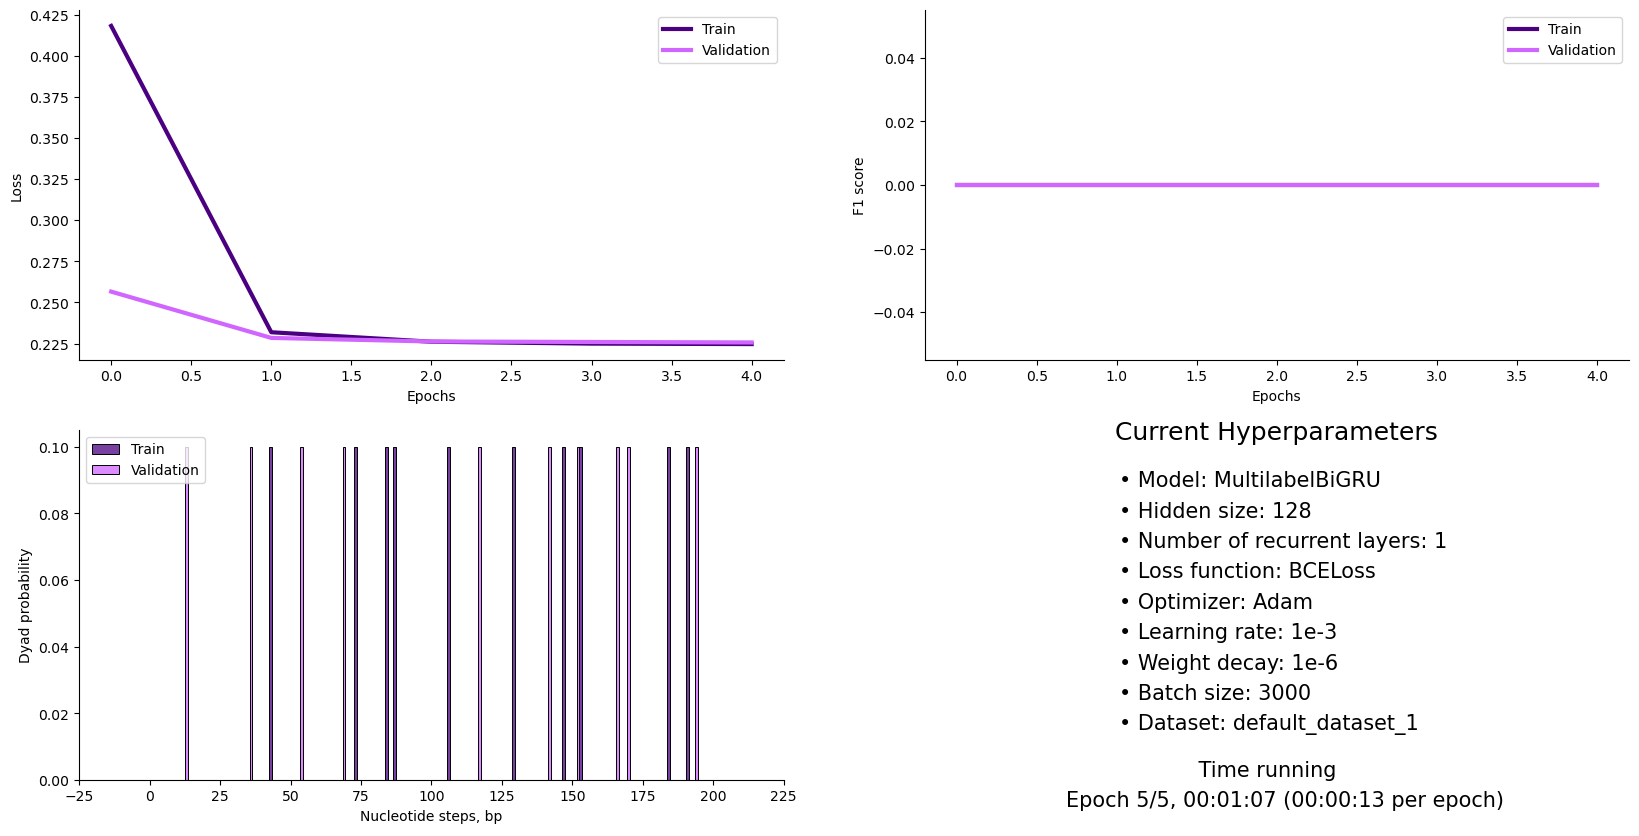

In [61]:
train(args=args)

#### Distributed training

##### Clear cuda cache from the notebook's kernel process

In [26]:
torch.cuda.empty_cache()

##### Make an entry point for a .py file

In [164]:
if __name__ == '__main__':
    if 'get_ipython' in globals():
        pass
    else:
        dist_train(world_size, args)

##### Save the notebook manually and execute the following cell to copy necessary cells to a .py file

In [53]:
with open('script.ipynb') as file:
    notebook = nbformat.read(file, as_version=4)

cells = []
for cell in notebook.cells:
    if cell.cell_type == 'code' and 'distributed' in cell.metadata.get('tags', []):
        cells.append(cell['source'])

with open('script.py', 'w') as file:
    for cell in cells:
        file.write(cell + '\n\n\n')

##### Run the following commands in the terminal while in this directory

```
conda activate DL_peak_calling && \
python script.py
```

##### Show dashboard at any moment while (or after) training distributedly

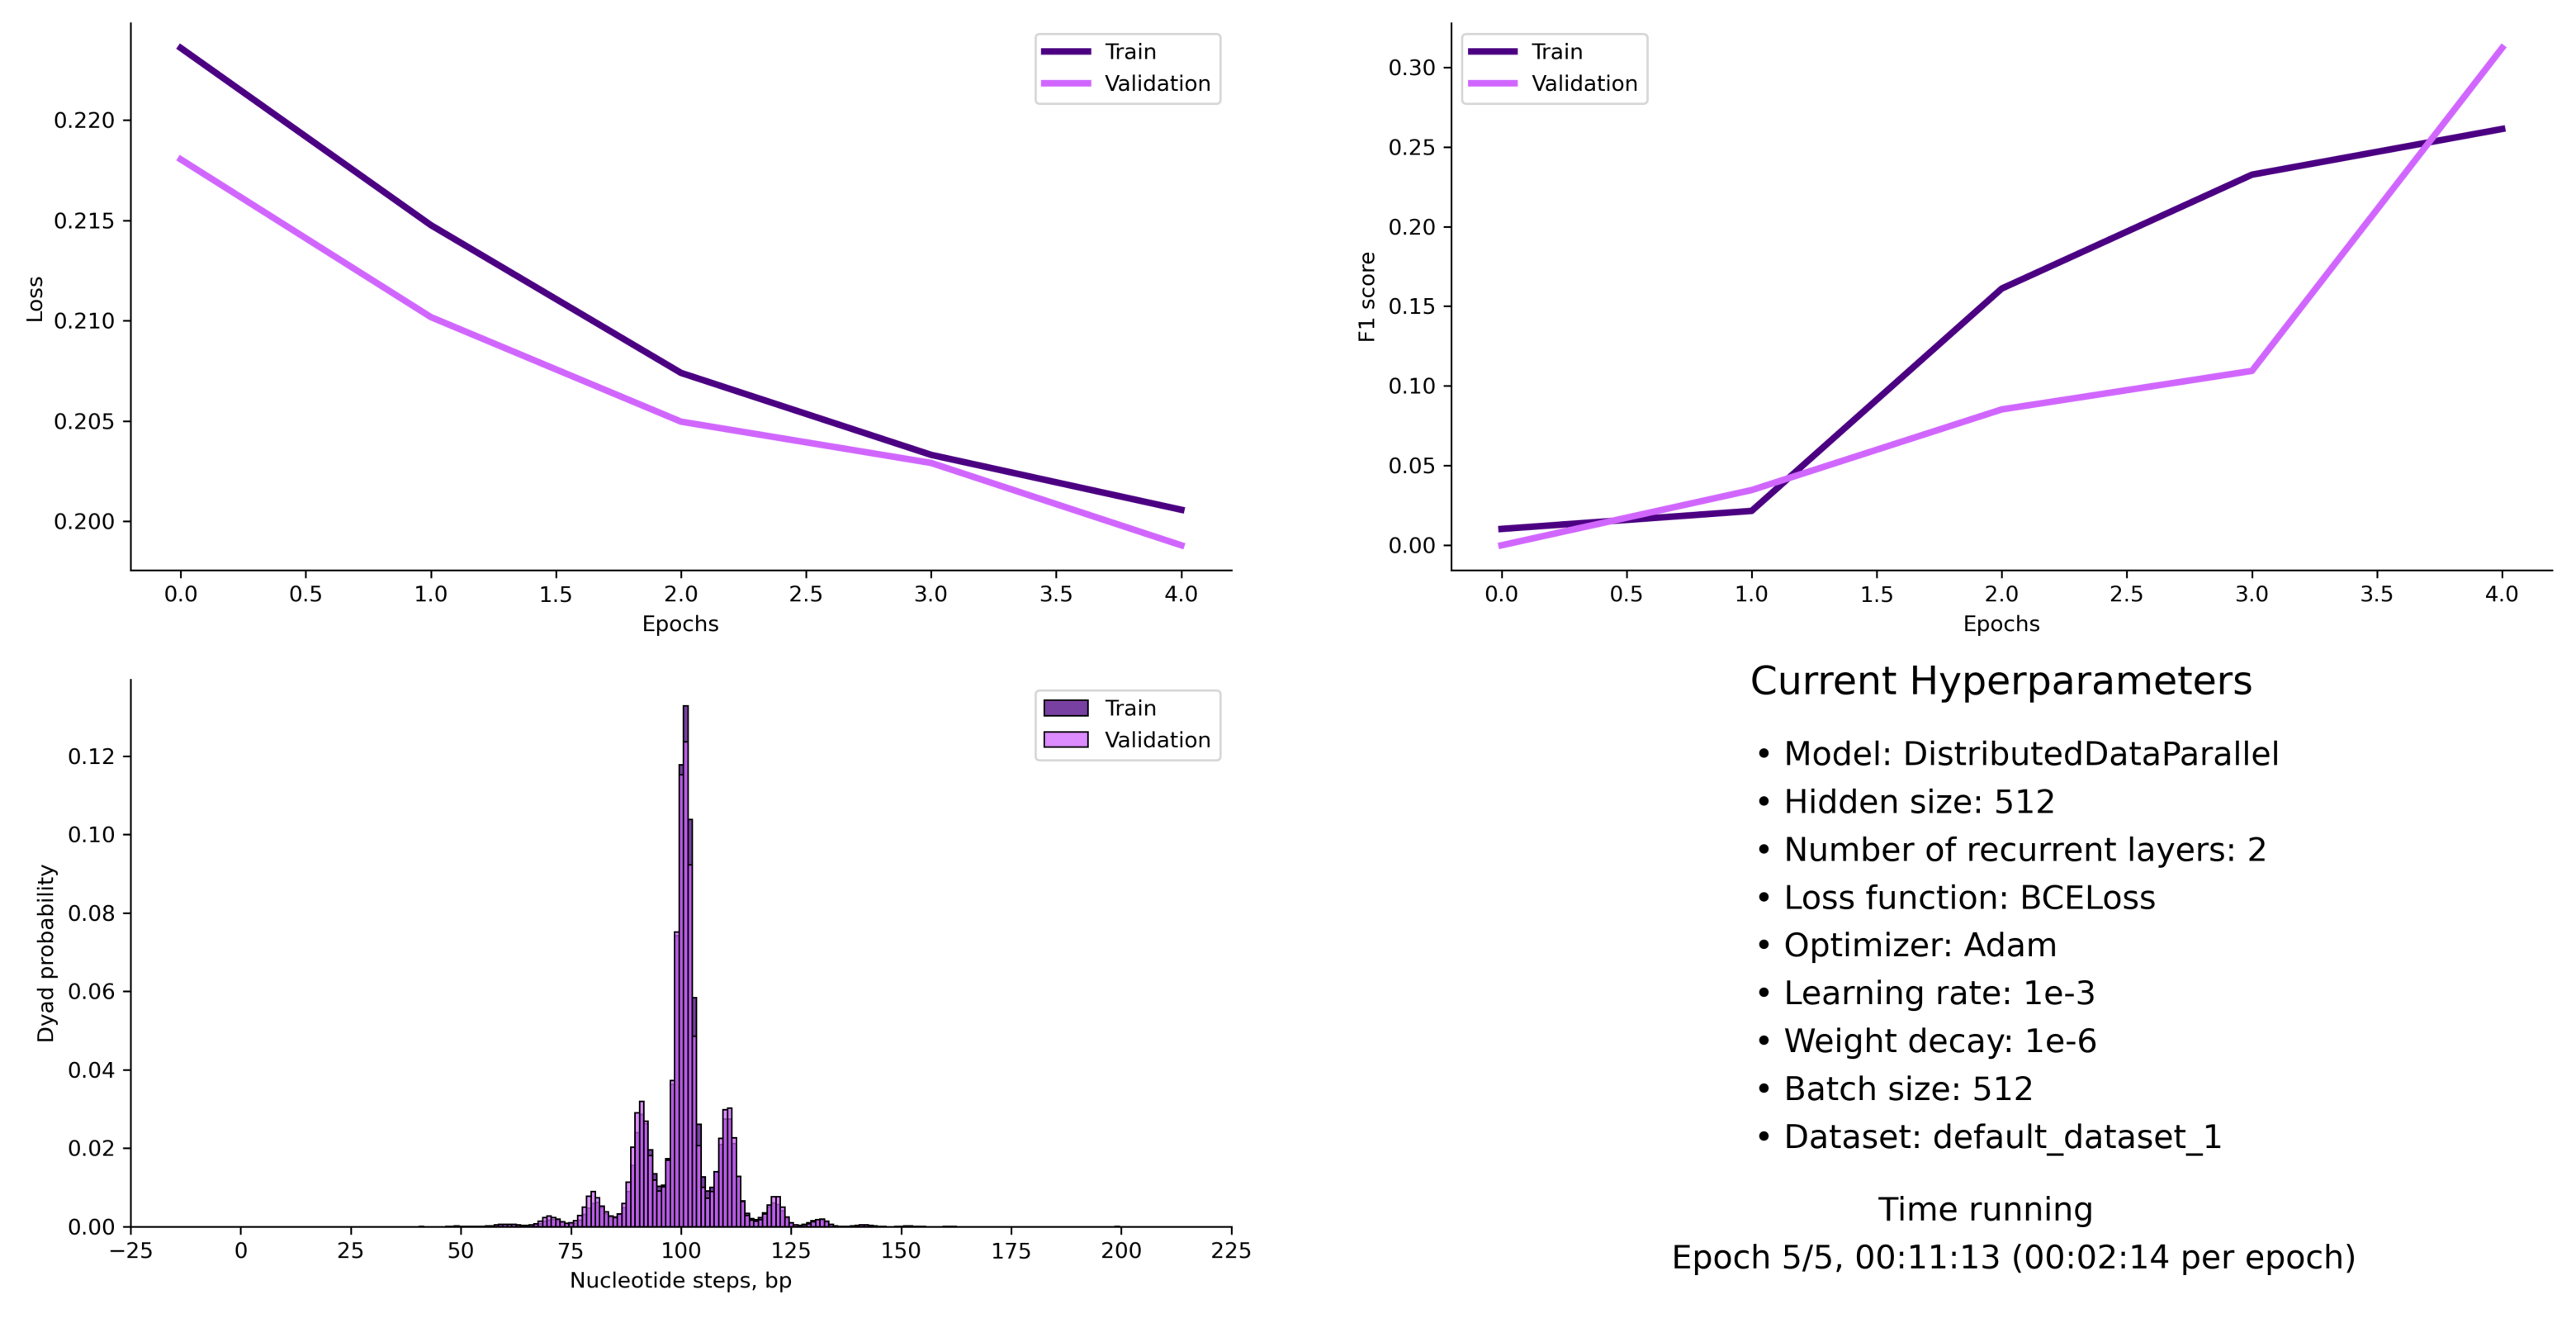

In [51]:
show_dashboard('512_2_multilabel')